# SpeedyWeather.jl showcase

An introduction to interactive climate modelling.
- Repository: https://github.com/SpeedyWeather/SpeedyWeather.jl
- Documentation: https://speedyweather.github.io

### 0. Load the packages

SpeedyWeather is a registered Julia package. Execute the following cell to install, use Julia 1.10, better 1.11

In [ ]:
using Pkg
# Pkg.add("SpeedyWeather") some functionality in this notebook requires the main branch
Pkg.add(url="https://github.com/SpeedyWeather/SpeedyWeather.jl", rev="main")
Pkg.add("GLMakie")
PKg.add("GeoMakie")

In [54]:
using SpeedyWeather
using GLMakie, GeoMakie    # for visualization

# 1. Define the resolution

A `SpectralGrid` object defines the resolution of a simulation both in spectral and grid space. Choose for example
- `trunc` the spectral truncation (highest wavenumber)
- `Grid` the grid being used (resolution is chosen from `trunc`)
- `nlayers` the number of vertical layers

In [58]:
spectral_grid = SpectralGrid(trunc=127, nlayers=1, Grid=OctaminimalGaussianGrid)

SpectralGrid:
├ Spectral:   T127 LowerTriangularMatrix{Complex{Float32}}, radius = 6.371e6 m
├ Grid:       192-ring OctaminimalGaussianGrid{Float32}, 37248 grid points
├ Resolution: 117km (average)
├ Vertical:   1-layer atmosphere, 2-layer land
└ Device:     CPU using Array

The `globe` function can visualise this nicely

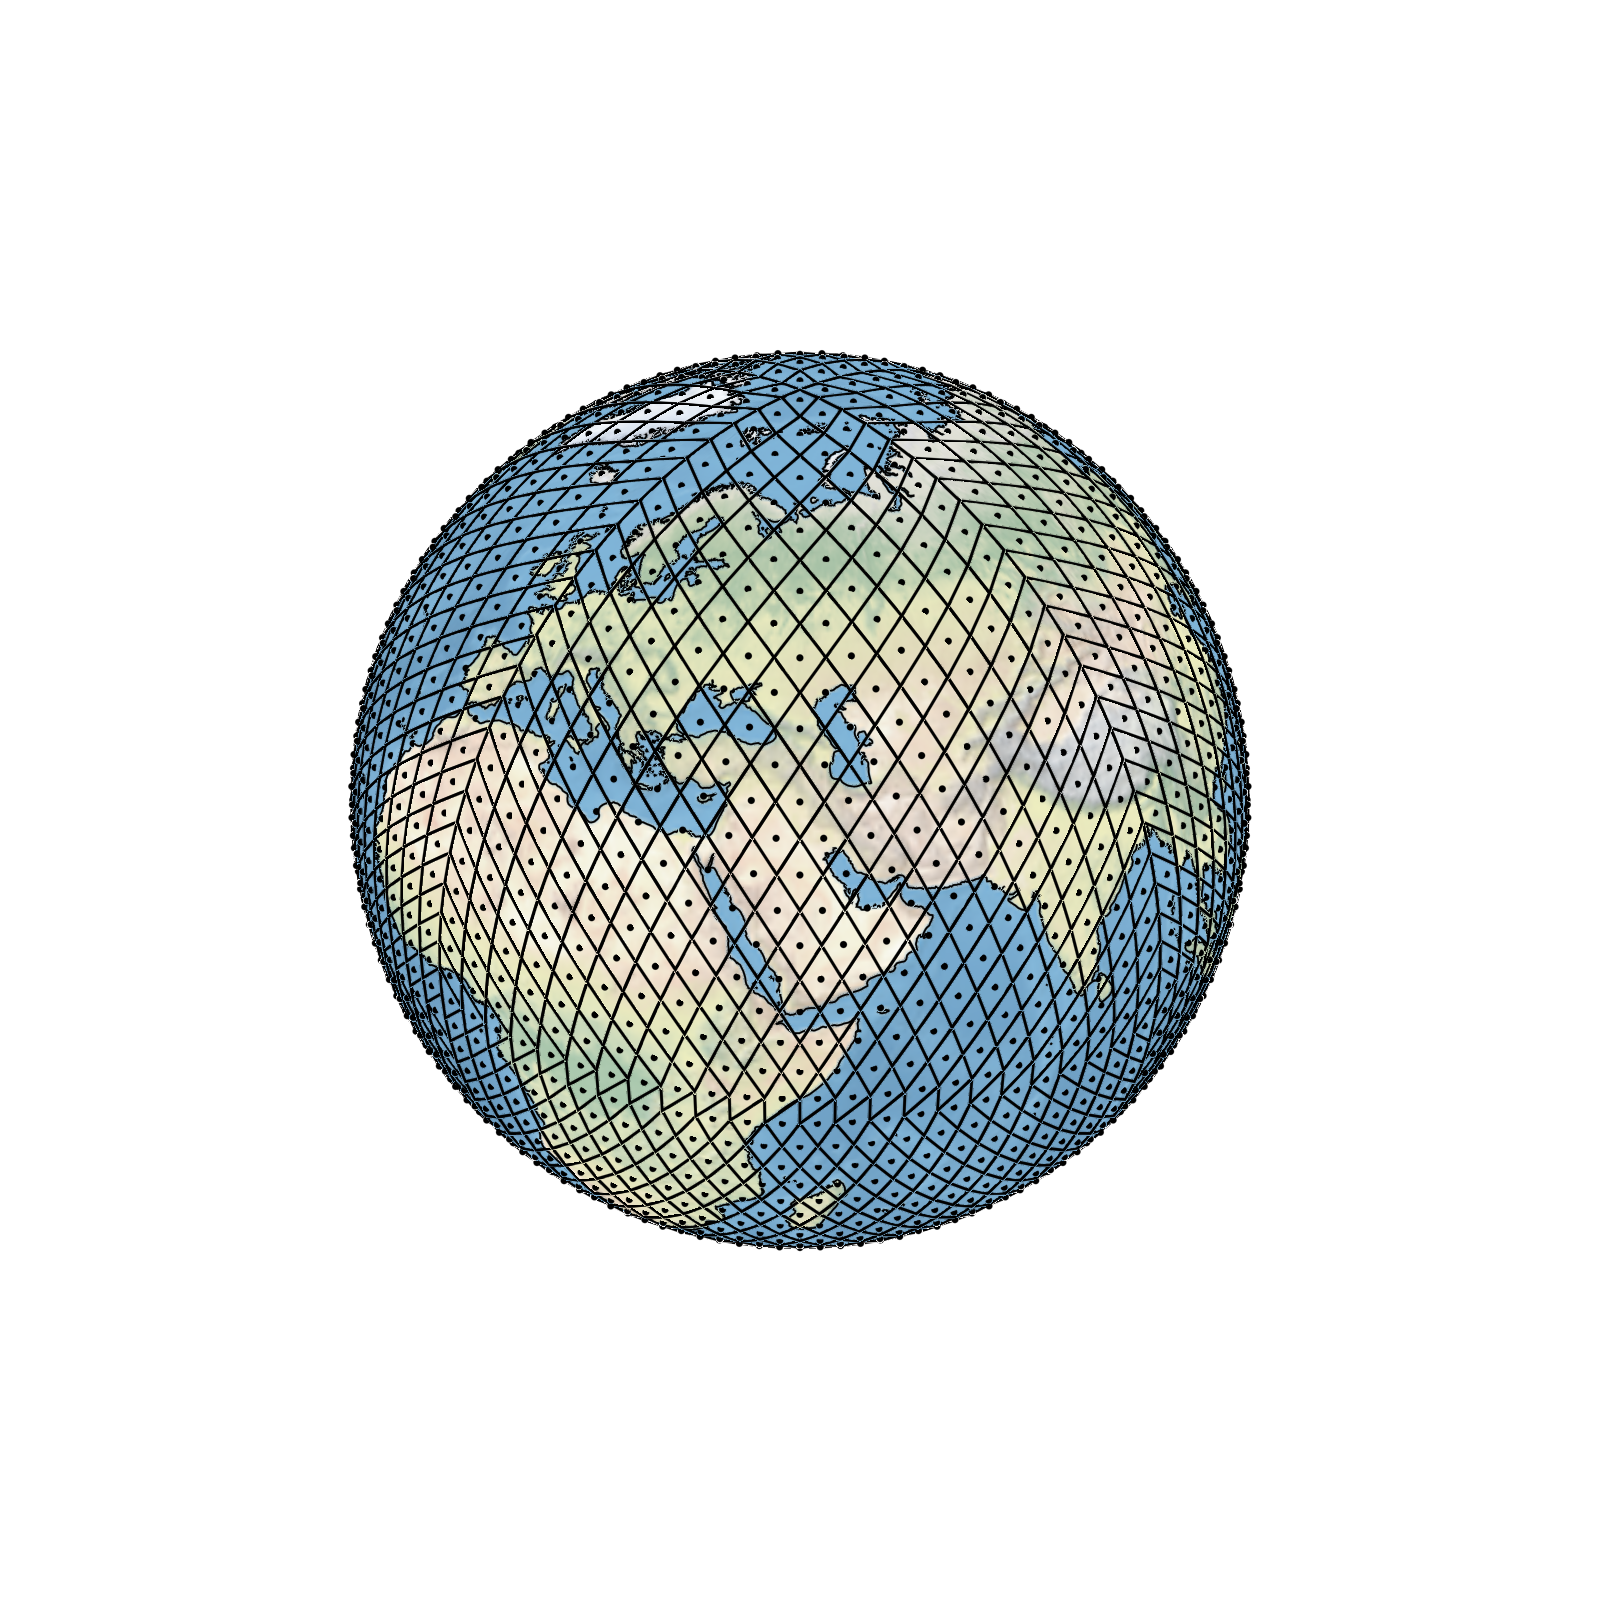

In [57]:
globe(spectral_grid)

# 2. Define model components

All components have a default, just define those you want to change

In [59]:
forcing = KolmogorovFlow(spectral_grid, wavenumber=8)

KolmogorovFlow{Float32} <: SpeedyWeather.AbstractForcing
├ strength::Float32 = 3.0e-12
└ wavenumber::Float32 = 8.0

# 3. Create a model

Create a `BarotropicModel`, just pass on any custom components like `forcing`

In [60]:
model = BarotropicModel(spectral_grid; forcing)

BarotropicModel <: Barotropic
├ spectral_grid: SpectralGrid
├ device_setup: SpeedyWeather.DeviceSetup{CPU, DataType}
├ geometry: Geometry{Float32, OctaminimalGaussianGrid, Vector{Float32}, Vector{Float64}}
├ planet: Earth{Float32}
├ atmosphere: EarthAtmosphere{Float32}
├ coriolis: Coriolis{Float32, Vector{Float32}}
├ forcing: KolmogorovFlow{Float32}
├ drag: LinearVorticityDrag{Float32}
├ particle_advection: NoParticleAdvection
├ initial_conditions: InitialConditions{RandomVelocity, ZeroInitially, ZeroInitially, ZeroInitially}
├ random_process: NoRandomProcess
├ tracers: Dict{Symbol, Tracer}
├ time_stepping: Leapfrog{Float32}
├ spectral_transform: SpectralTransform{Float32, Array, Vector{Float32}, Vector{ComplexF32}, Matrix{ComplexF32}, Array{ComplexF32, 3}, LowerTriangularMatrix{Float32}, LowerTriangularArray{Float32, 2, Matrix{Float32}}}
├ implicit: NoImplicit
├ horizontal_diffusion: HyperDiffusion{Float32, Matrix{Float32}}
├ output: NetCDFOutput{FullGaussianGrid{Float32}, FullGaussia

# 4. Initialize the simulation

This steps allows all components to talk to each other, initializes them, and allocates the variables

In [61]:
simulation = initialize!(model)

Simulation{BarotropicModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::BarotropicModel{...}

# 5. Run the simulation!

Weather is speedy: 100%|██████████████████| Time: 0:00:00 (530.25 years/day)


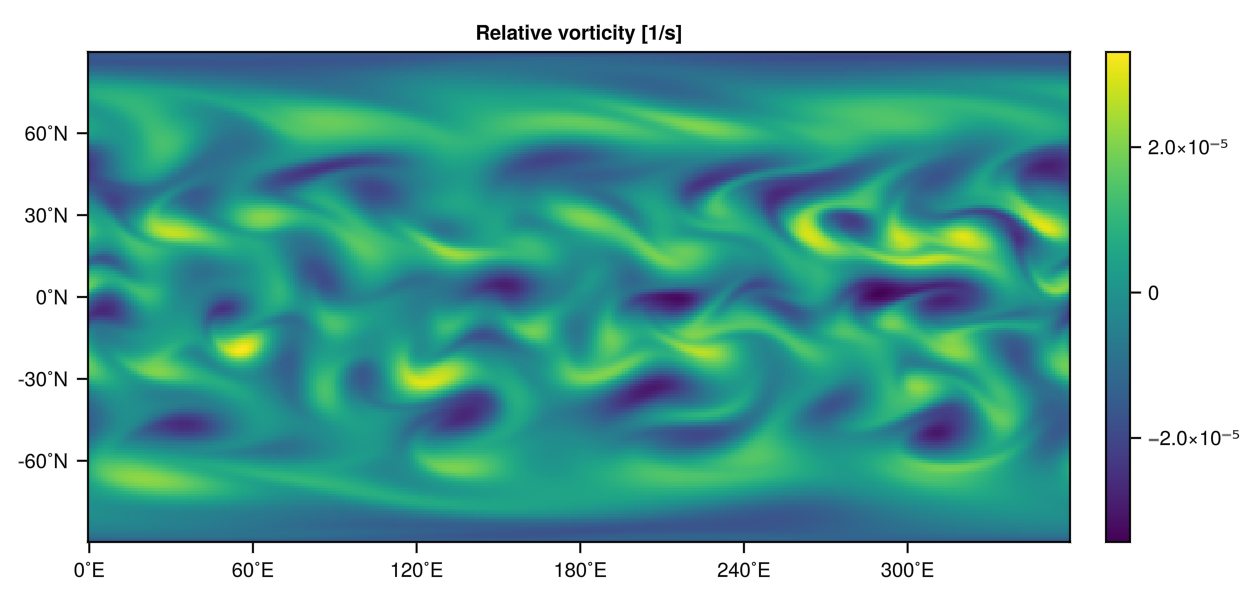

In [63]:
run!(simulation, period=Day(2))

# visualise it!
vor = simulation.diagnostic_variables.grid.vor_grid[:, 1]  # vorticity on layer 1
heatmap(vor, title="Relative vorticity [1/s]")

# Change to a shallow water simulation?

SpeedyWeather is several models in one, we have
- `BarotropicModel`, 2D barotropic vorticity equations
- `ShallowWaterModel`, 2D shallow water equations
- `PrimitiveDryModel`, 3D primitive equations _without_ humidity
- `PrimitiveWetModel`, 3D primitive equations _with_ humidity

In [64]:
model2 = ShallowWaterModel(spectral_grid; forcing)   # reuse components from above
simulation2 = initialize!(model2)

Simulation{ShallowWaterModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::ShallowWaterModel{...}

# Initial conditions from previous simulation

Like changing the equations halfway through a simulation! This
- introduces new prognostic variables (divergence and pressure)
- uses Earth's orography

In [65]:
set!(simulation2, vor=simulation.prognostic_variables.vor[1])

# Continue simulation with new equations (barotropic -> shallow water)

Weather is speedy: 100%|██████████████████| Time: 0:00:03 (119.04 years/day)


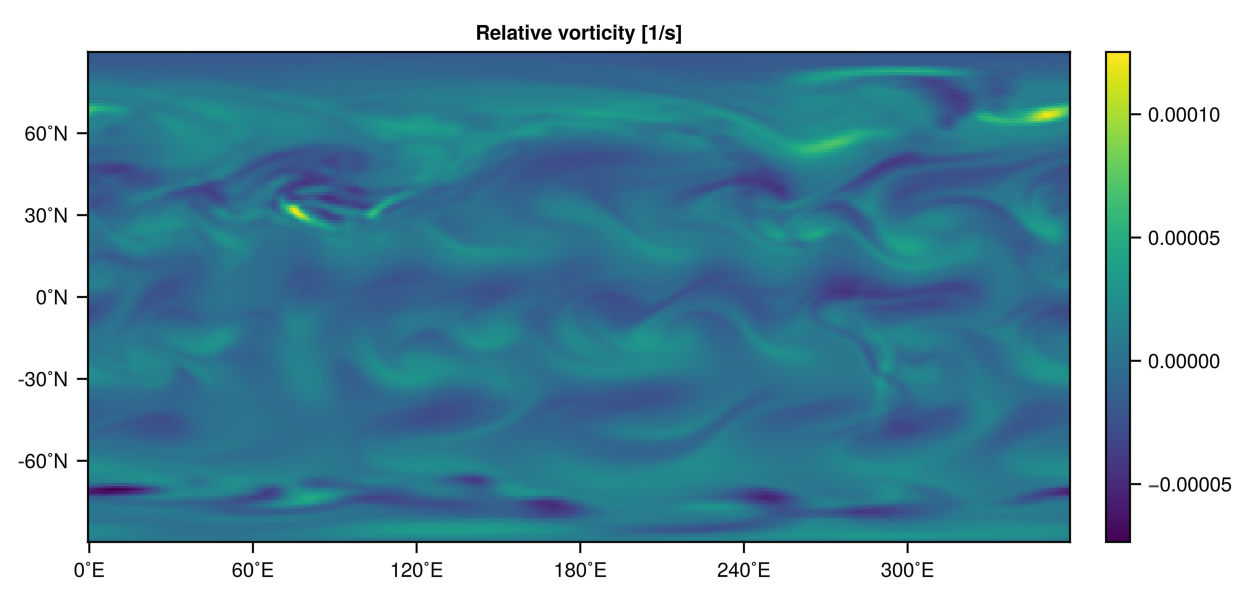

In [66]:
run!(simulation2, period=Day(2))

# visualise it!
vor = simulation2.diagnostic_variables.grid.vor_grid[:, 1]  # vorticity on layer 1
heatmap(vor, title="Relative vorticity [1/s]")

Mountains have clearly affected the Kolmogorov flow!

# Let's go 3D! 1. Define resolution

Okay but 2D models are simple, so let us solve the 3D primitive equations, simulating the whole atmosphere with convection, precipitation, radiation, land, ocean, ...

In [67]:
spectral_grid = SpectralGrid(trunc=63, nlayers=8, Grid=OctaminimalGaussianGrid)

SpectralGrid:
├ Spectral:   T63 LowerTriangularMatrix{Complex{Float32}}, radius = 6.371e6 m
├ Grid:       96-ring OctaminimalGaussianGrid{Float32}, 9408 grid points
├ Resolution: 233km (average)
├ Vertical:   8-layer atmosphere, 2-layer land
└ Device:     CPU using Array

# 2. Define some components for land and ocean

In [68]:
land_temperature = LandBucketTemperature(spectral_grid)
soil_moisture = LandBucketMoisture(spectral_grid, time_scale=Day(2))
land = LandModel(spectral_grid; temperature=land_temperature, soil_moisture)
ocean = SlabOcean(spectral_grid);

### Use functions f(λ, φ) to set fields

In [69]:
albedo = Albedo(ocean=GlobalConstantAlbedo(spectral_grid, albedo=0.1),
                land=ManualAlbedo(spectral_grid))

set!(albedo.land, (λ, φ) -> 0.3 + 0.2*abs(φ)/90);    # uses Unicode too!

# 3+4. Construct and initialize the model

Pass on all the customized components

In [70]:
model = PrimitiveWetModel(spectral_grid; land, albedo, ocean)
simulation = initialize!(model)

Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

# A land-sea mask flipped around the Equator?

_Do something the developer does not want you to do but you still can!_

But note that orography is still the correct way around! So Indian ocean is now on the top of Mt Everest

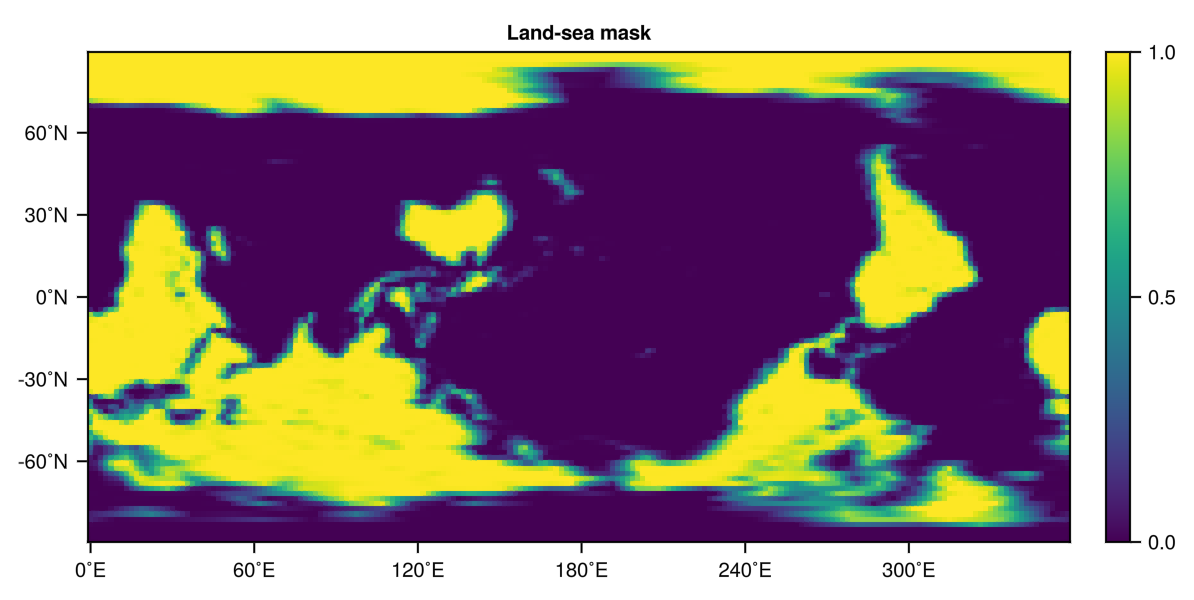

In [71]:
reverse!(model.land_sea_mask.mask, dims=:lat)
heatmap(model.land_sea_mask.mask, title="Land-sea mask")

# 5. Run it!

Weather is speedy: 100%|██████████████████| Time: 0:00:07 (162.95 years/day)


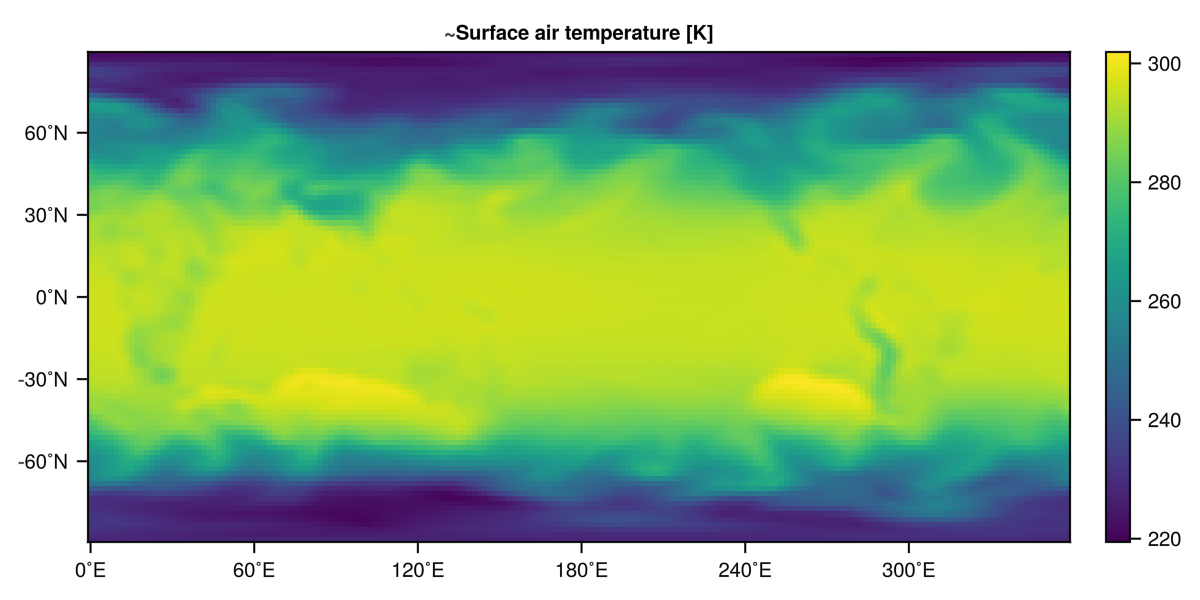

In [72]:
run!(simulation, period=Day(5))

# and visualise surface temperature
temperature = simulation.diagnostic_variables.grid.temp_grid[:, 8]
heatmap(temperature, title="~Surface air temperature [K]")

Now there's a ghost Asian continent between "Africa" and "Australia" and a ghost North America appears of the Chilean cost

# Analyse the soil moisture

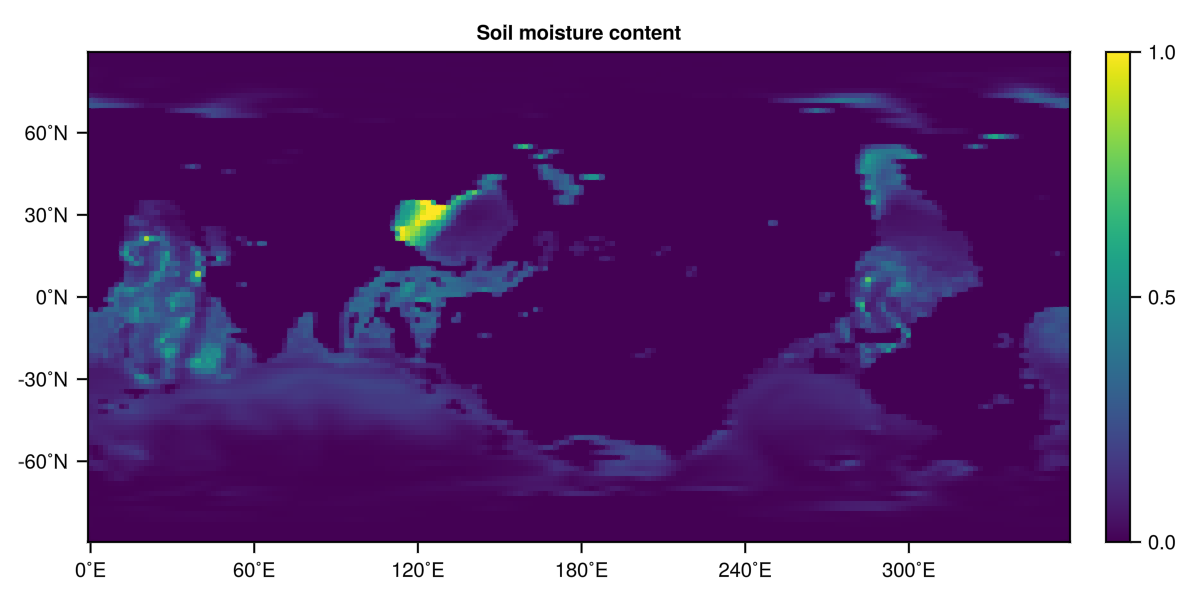

In [73]:
soil_moisture = simulation.prognostic_variables.land.soil_moisture[:, 1]
heatmap(soil_moisture, title="Soil moisture content")

# Volcanic eruption in the Pacific?

Just set the orography to something else!

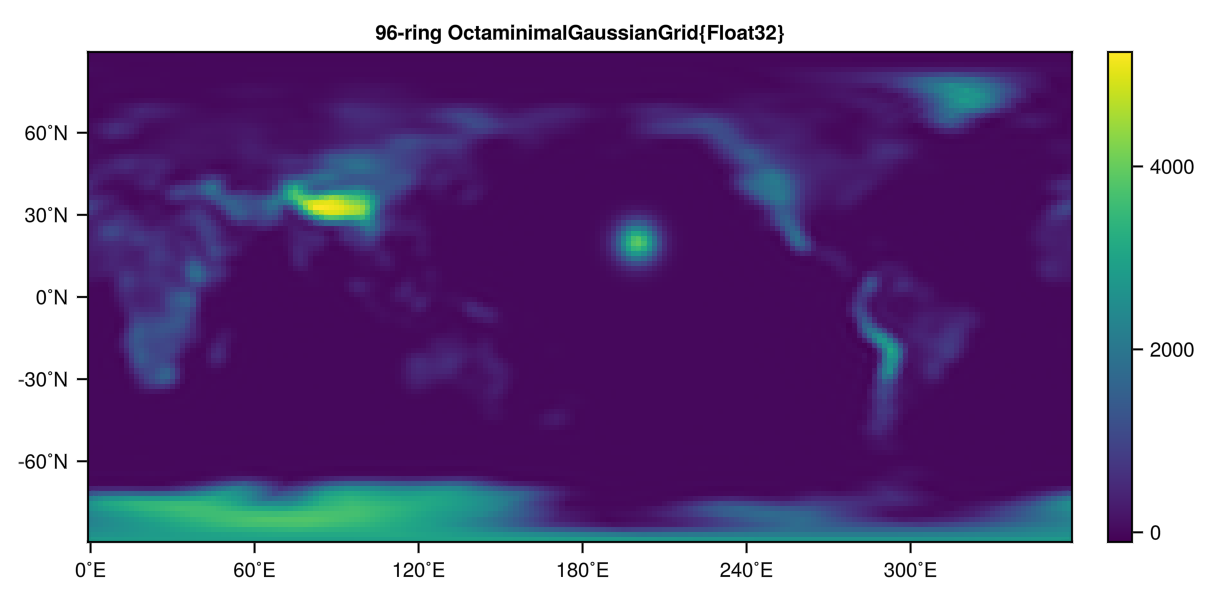

In [74]:
H, λ₀, φ₀, w = 4000, 200, 20, 5         # height, lon, lat position, and width
set!(model, orography=(λ,φ) -> H*exp((-(λ-λ₀)^2 - (φ-φ₀)^2)/2w^2), add=true)
heatmap(model.orography.orography)

# Volcanic eruption: Add a tracer!

Tracers can be added halfway through a simulation. This introduces a new prognostic variable called `ash` that is advected passively with the flow.

In [75]:
add!(simulation, Tracer(:ash))

# initial conditions of ash
set!(simulation, ash = (λ, φ, σ) -> σ*exp((-(λ-λ₀)^2 - (φ-φ₀)^2)/2(3w)^2))

# Continue the simulation, where does the ash go?

Now we continue the previous simulation, but the ash from the volcano is now blown around by the wind

Weather is speedy: 100%|██████████████████| Time: 0:00:01 (143.62 years/day)


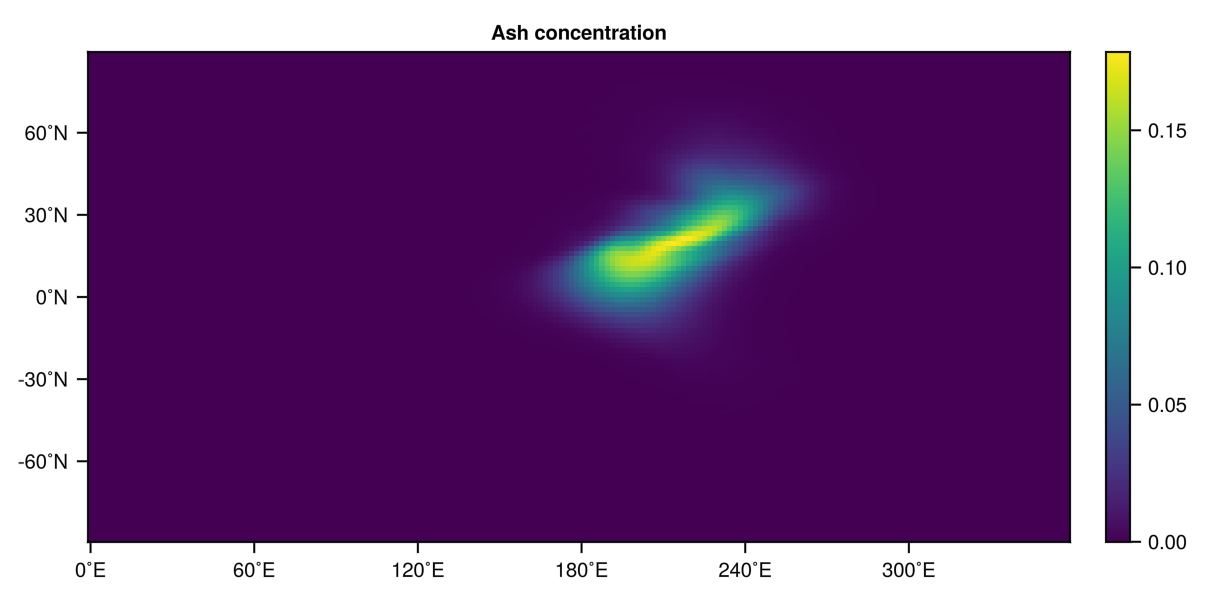

In [76]:
run!(simulation, period=Day(1))

# visualise
ash = simulation.diagnostic_variables.grid.tracers_grid[:ash][:, 2]
heatmap(ash, title="Ash concentration")

Weather is speedy: 100%|██████████████████| Time: 0:00:08 (146.59 years/day)


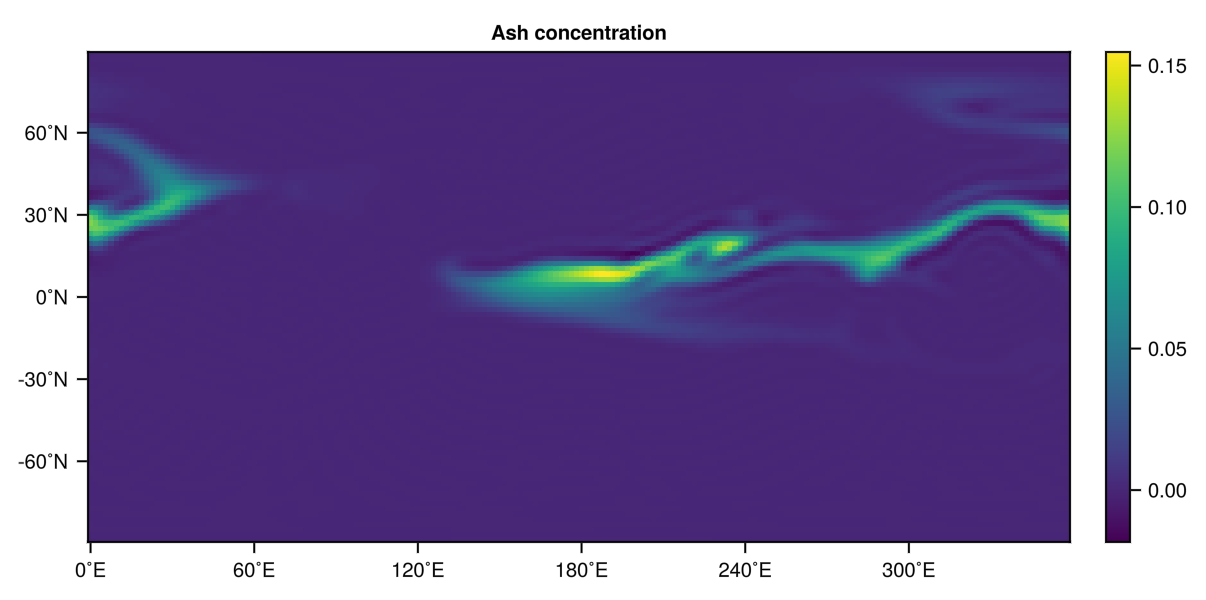

In [77]:
run!(simulation, period=Day(5))

# visualise
ash = simulation.diagnostic_variables.grid.tracers_grid[:ash][:, 2]
heatmap(ash, title="Ash concentration")